# Let's start our work with data:
Firstly, wee can see that dataset folder is nested in a folder with the same name. Fix this by moving all character folders to the "data/simpsons_dataset".
Now find out how many images each class has

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms, models
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_train_path = "data/simpsons_dataset_copy"
data_test_path = "data/simpsons_testset"
bs = 256

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.ConvertImageDtype(dtype=torch.float32),
                                  transforms.Resize([100, 100]),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                  # transforms.Normalize(mean=[0.5], std=[0.25])]
                                )

characters = {}

class_labels = os.listdir(data_train_path)
    
num_classes = len(class_labels)

In [6]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_labels)
print(encoded_labels)
print(class_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [7]:
for i in range(num_classes):
    characters[i] = []
    folder_path = os.path.join(data_train_path, class_labels[i])
    for image in os.listdir(folder_path):
        characters[i].append(cv2.imread(os.path.join(folder_path, image)))

In [8]:
train_data = []
val_data = []

for character, images in characters.items():
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=54)
    train_data.extend([(transform(img), character) for img in train_images])
    val_data.extend([(transform(img), character) for img in val_images])

# Создание DataLoader для train и val данных
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs, shuffle=True)

In [9]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [19]:
model = CustomResNet(num_classes=num_classes)
model = model.to(device)
model.load_state_dict(torch.load('custom_resnet_weights.pth'))
criterion = nn.CrossEntropyLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


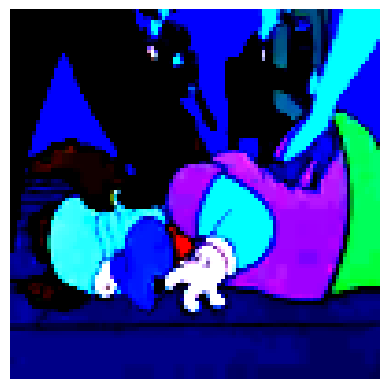

16
['krusty_the_clown']


In [20]:
# Iterate over the train_loader to get the first batch
for images, labels in train_loader:
    first_image = images[0].numpy()
    plt.imshow(np.transpose(first_image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    # print(labels[0].item().type)
    print(labels[0].item())
    print(label_encoder.inverse_transform([int(labels[0].item())]))
    break

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

len_loader = len(train_loader)
loss_train_arr = []
loss_val_arr = []

for epoch in range(num_epochs):
    model.train()
    i = 1
    running_loss = 0.0
    for images, labels in train_loader:
        print(f'\rIteration: {i} / {len_loader}', end='', flush=True)
        i += 1
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # print(predicted)
        # print(labels.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    lr_scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        auc_roc_list = []

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            predictions_onehot = torch.zeros(len(predicted), 42, device=device)
            predictions_onehot.scatter_(1, predicted.unsqueeze(1), 1)

            targets_onehot = torch.zeros(len(labels), 42, device=device)
            targets_onehot.scatter_(1, labels.unsqueeze(1), 1)

            conf_matrix = confusion_matrix(targets_onehot.cpu().numpy().argmax(axis=1), predictions_onehot.cpu().numpy().argmax(axis=1))

            for class_idx in range(conf_matrix.shape[0]):
                TP = conf_matrix[class_idx, class_idx]
                FP = conf_matrix[:, class_idx].sum() - TP
                FN = conf_matrix[class_idx, :].sum() - TP

                accuracy = TP / (TP + FP + FN)
                precision = TP / (TP + FP) if TP + FP != 0 else 0
                recall = TP / (TP + FN) if TP + FN != 0 else 0
                f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

                # print(f'Class {class_idx}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1_score}')

                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1_score)

        avg_accuracy = sum(accuracy_list) / len(accuracy_list)
        avg_precision = sum(precision_list) / len(precision_list)
        avg_recall = sum(recall_list) / len(recall_list)
        avg_f1 = sum(f1_list) / len(f1_list)

        train_loss = running_loss/len(train_loader)
        val_loss = loss.item()
        print(f'\nEpoch: {epoch+1}, Training loss: {train_loss}, Validation loss: {val_loss}, Average Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')
        loss_val_arr.append(val_loss)
        loss_train_arr.append(train_loss)

Iteration: 94 / 94
Epoch: 1, Training loss: 0.7097947724322056, Validation loss: 0.21825504302978516, Average Accuracy: 0.7813315682749644, Average Precision: 0.8948887403720832, Average Recall: 0.8534238584778943, Average F1-score: 0.8552778043901874
Iteration: 94 / 94
Epoch: 2, Training loss: 0.21213291046467234, Validation loss: 0.33402037620544434, Average Accuracy: 0.8008232699247975, Average Precision: 0.8930113969407641, Average Recall: 0.8787856349917456, Average F1-score: 0.8678958838330872
Iteration: 94 / 94
Epoch: 3, Training loss: 0.13691538508902204, Validation loss: 0.21261081099510193, Average Accuracy: 0.8491530571868214, Average Precision: 0.922157618269305, Average Recall: 0.9137150570283102, Average F1-score: 0.9050058762862818
Iteration: 94 / 94
Epoch: 4, Training loss: 0.061815441962569315, Validation loss: 0.0047141313552856445, Average Accuracy: 0.9126600505611316, Average Precision: 0.9533887405201998, Average Recall: 0.9502195393435284, Average F1-score: 0.9462

In [12]:
torch.save(model.state_dict(), 'custom_resnet_weights.pth')

In [21]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
X_test = []
y_test = []

for file in os.listdir(data_test_path):
    y_test.append('_'.join(file.split('_')[:-1]))
    X_test.append(cv2.imread(os.path.join(data_test_path, file)))

X_test = [transform(image) for image in X_test]
y_test = label_encoder.transform(y_test)
y_test = y_test.astype(np.int64)

In [23]:
transform_test = transforms.Compose([
                                  transforms.ConvertImageDtype(dtype=torch.float32),
                                  transforms.Resize([100, 100]),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                  # transforms.Normalize(mean=[0.5], std=[0.25])]
                                )

In [24]:
custom_dataset = CustomDataset(images=X_test, labels=y_test, transform=transform_test)

In [25]:
test_loader = DataLoader(custom_dataset, batch_size=bs, shuffle=True)

In [26]:
model.eval()
loss_test_arr = []
with torch.no_grad():
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    
    for images, labels in test_loader:
            
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels.long())
        loss_test_arr.append(loss.item())
        
        predictions_onehot = torch.zeros(len(predicted), num_classes, device=device)
        predictions_onehot.scatter_(1, predicted.unsqueeze(1), 1)

        targets_onehot = torch.zeros(len(labels), num_classes, device=device)
        targets_onehot.scatter_(1, labels.unsqueeze(1), 1)

        conf_matrix = confusion_matrix(targets_onehot.cpu().numpy().argmax(axis=1), predictions_onehot.cpu().numpy().argmax(axis=1))

        for class_idx in range(conf_matrix.shape[0]):
            TP = conf_matrix[class_idx, class_idx]
            FP = conf_matrix[:, class_idx].sum() - TP
            FN = conf_matrix[class_idx, :].sum() - TP

            accuracy = TP / (TP + FP + FN)
            precision = TP / (TP + FP) if TP + FP != 0 else 0
            recall = TP / (TP + FN) if TP + FN != 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

            print(f'Class {class_idx}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1_score}')

            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1_score)

    avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)

    print(f'\nAverage Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')

Class 0: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 1: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 2: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 3: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 4: Accuracy: 0.06532663316582915, Precision: 0.06565656565656566, Recall: 0.9285714285714286, F1-score: 0.12264150943396228
Class 5: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 6: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 7: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 8: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 9: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 10: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 11: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 12: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 13: Accuracy: 0.0, Precision: 0, Recall: 0.0, F1-score: 0
Class 14: Accuracy: 0.0, Precision: 0, Recall: 

In [19]:
def plot_graph(data_list):
    plt.plot(data_list)
    plt.show()

test loss


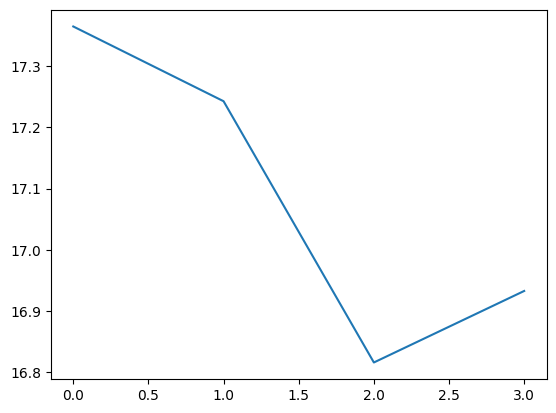

train loss


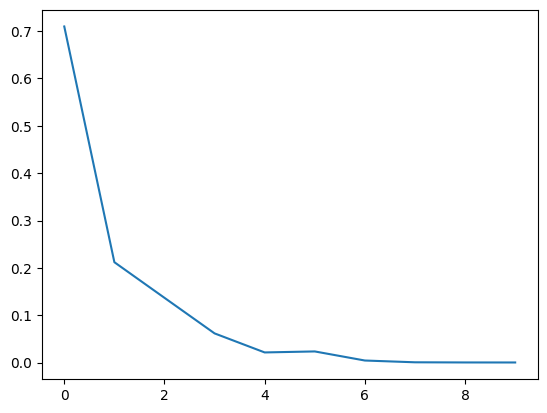

val loss


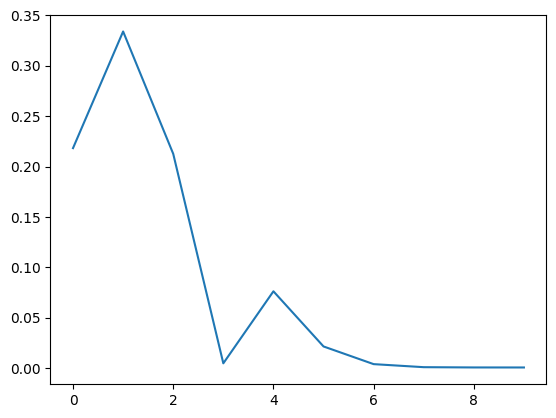

In [20]:
print('test loss')
plot_graph(loss_test_arr)
print('train loss')
plot_graph(loss_train_arr)
print('val loss')
plot_graph(loss_val_arr)

In [44]:
len_total = 0
for i in range(len(characters)):
    print(i, len(characters[i]))
    len_total += len(characters[i])

0 913
1 623
2 520
3 1342
4 512
5 1193
6 986
7 507
8 515
9 192
10 503
11 510
12 510
13 512
14 2246
15 521
16 1206
17 517
18 72
19 1354
20 519
21 1291
22 508
23 522
24 1079
25 408
26 1452
27 1454
28 519
29 515
30 509
31 1194
32 502
33 505
34 503
35 517
36 877
37 500
38 515
39 192
40 503


In [11]:
# Validation
model.eval()
with torch.no_grad():
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    auc_roc_list = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        predictions_onehot = torch.zeros(len(predicted), 42, device=device)
        predictions_onehot.scatter_(1, predicted.unsqueeze(1), 1)

        targets_onehot = torch.zeros(len(labels), 42, device=device)
        targets_onehot.scatter_(1, labels.unsqueeze(1), 1)

        conf_matrix = confusion_matrix(targets_onehot.cpu().numpy().argmax(axis=1), predictions_onehot.cpu().numpy().argmax(axis=1))

        for class_idx in range(conf_matrix.shape[0]):
            TP = conf_matrix[class_idx, class_idx]
            FP = conf_matrix[:, class_idx].sum() - TP
            FN = conf_matrix[class_idx, :].sum() - TP

            accuracy = TP / (TP + FP + FN)
            precision = TP / (TP + FP) if TP + FP != 0 else 0
            recall = TP / (TP + FN) if TP + FN != 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

            # print(f'Class {class_idx}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1_score}')

            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1_score)

        avg_accuracy = sum(accuracy_list) / len(accuracy_list)
        avg_precision = sum(precision_list) / len(precision_list)
        avg_recall = sum(recall_list) / len(recall_list)
        avg_f1 = sum(f1_list) / len(f1_list)

    print(f'\nEpoch: {epoch+1}, Validation loss: {loss.item()}, Average Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


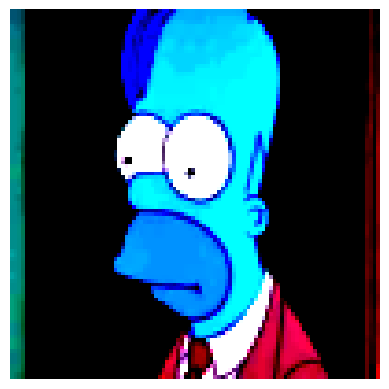

14
['homer_simpson']


In [34]:
# Iterate over the train_loader to get the first batch
for images, labels in train_loader:
    first_image = images[0].numpy()
    plt.imshow(np.transpose(first_image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    # print(labels[0].item().type)
    print(labels[0].item())
    print(label_encoder.inverse_transform([int(labels[0].item())]))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6, device='cuda:0')


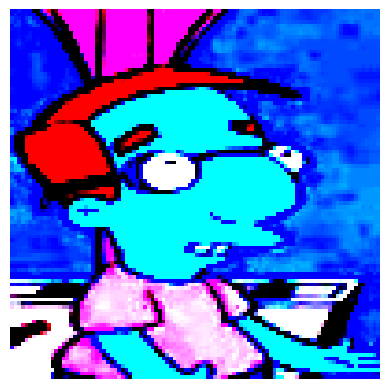

24
['milhouse_van_houten']


In [47]:
# Iterate over the train_loader to get the first batch
for images, labels in test_loader:
    first_image = images[0].numpy()
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print(predicted[0])
    
    plt.imshow(np.transpose(first_image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    # print(labels[0].item().type)
    print(labels[0].item())
    print(label_encoder.inverse_transform([int(labels[0].item())]))
    break